In [1]:
import numpy as np
import pandas as pd
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import imblearn
from sklearn.datasets import make_classification
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours

In [2]:
#FUNCAO PARA CRIAR UM GRAFICO DE DISPERCAO
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

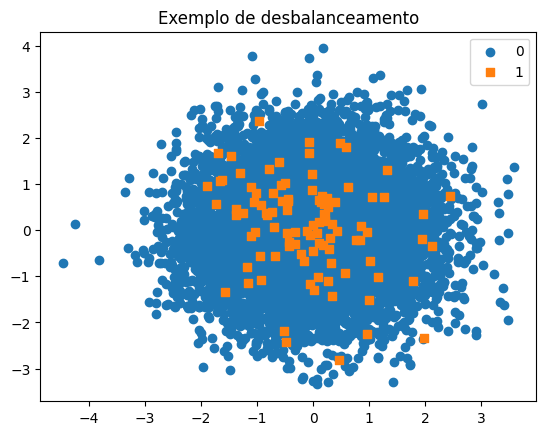

In [3]:
#EXEMPLO GERAL DE DESBALANCEADOS
X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.99, 0.01],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=10000, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
    
plot_2d_space(X, y, 'Exemplo de desbalanceamento')    

In [4]:
#LEITURA DOS DADOS
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'link'
fluff, id = link.split('=')
#print (id) # Verificar o real caminho do link '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
df_train = pd.read_csv('train.csv')

ValueError: ignored

In [ ]:
#IDENTIFICAR DESBALANCEAMENTO DOS DADOS
target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [ ]:
#XGBC SEM NENHUM TRATAMENTO NA BASE
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#REPLICAMOS O MESMO CODIGO SO CONSIDERANDO APENAS UMA VARIVEL QUE PROVAVELMENTE ERA PARA A ACURACIA REDUZIR DRAMASTICAMENTE. JA QUE NAO REDUZIU, REFORCA
#O FATO DO ALGORITMO NAO ESTEJA BEM CALIBRADO
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#MATRIZ DE CONFUSAO REFORCA O FATO DE QUE OS DADOS ESTAO DESBALANCEADOS
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
#CONTAR AS CLASSIFICACOES
count_class_0, count_class_1 = df_train.target.value_counts()

#DIVIDE O DATA FRAME POR CLASSIFICACAO
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [ ]:
#EQUALIZANDO A BASE POR UNDER SAMPLING
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [ ]:
#XGBC NA BASE UNDER SAMPLING
labels = df_test_under.columns[2:]

X = df_test_under[labels]
y = df_test_under['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#EQUALIZANDO A BASE POR OVER SAMPLING
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
#XGBC NA BASE OVER SAMPLING
labels = df_test_over.columns[2:]

X = df_test_over[labels]
y = df_test_over['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#EXEMPLO REDUZIDO PARA EXEMPLIFICACAO
X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');


In [ ]:
#APLICAR A FUNCAO RandomUnderSampler
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

rus = RandomUnderSampler(return_indices=True,random_state=0, replacement=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [ ]:
#EXECUTAR O XGBC UNDER SAMPLING
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#NEARMISS UTILIZA 3 TIPOS DE HEURISTICAS QUE PODE SER SELECIONADO ALTERANDO O PARAMETRO VERSION, AS HEURISTICAS SAO BEADAS NOS VIZINHOS PROXIMOS
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X_resampled_nm1, y_resampled = nm1.fit_resample(X, y)

In [ ]:
#EXECUTAR O XGBC NEARMISS SAMPLING
X_train, X_test, y_train, y_test = train_test_split(X_resampled_nm1, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#TOMEKSLINK EXISTE SE 2 OBSERVACOES SAO VIZINHO PROXIMO PARA CADOS DE UNDER SAMPLING
tl = TomekLinks(return_indices=True, sampling_strategy='all')
X_tl, y_tl, id_tl = tl.fit_resample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

In [ ]:
#EXECUTAR O XGBC TOMEKSLINK SAMPLING USANDO O PARAMETRO ALL
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#APLICA O ALGORITMO VIZINHO PROXIMOS E REMOVE AS OBSERVACOES QUE NAO SE ENQUADRAM, EXISTEM DOIS CRITERIOS DISPONIVEIS: MAJORITY OU ALL
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X, y)

plot_2d_space(X_resampled, y_resampled, 'Tomek links under-sampling')

In [ ]:
#EXECUTAR O XGBC EditedNearestNeighbours
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#UMA EXTENSAO DO RepeatedEditedNearestNeighbours  E DO EditedNearestNeighbours, A CADA INTERACAO FEITA, É AUMENTADO A QUANTIDADE DE VIZINHOS PROXIMOS
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
X_resampled, y_resampled = allknn.fit_resample(X, y)

In [ ]:
#EXECUTAR O XGBC AllKNN
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#A REGRA SE CONCENTRARA EM LIMPAR OS DADOS DO QUE CONDENSA-LOS
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(X, y)

In [ ]:
#EXECUTAR O XGBC NeighbourhoodCleaningRule
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#APLICAR A FUNCAO RandomOverSampler
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

rus = RandomOverSampler(return_indices=True,random_state=0, replacement=True)
X_ros, y_ros, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_ros)

plot_2d_space(X_ros, y_ros, 'Random under-sampling')

In [ ]:
#EXECUTAR O XGBC OVER SAMPLING
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#APLICAR A FUNCAO SMOTE E EXECUTAR O XGBC
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#APLICAR A FUNCAO ADASYN E EXECUTAR O XGBC
X_resampled, y_resampled = ADASYN().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))